# Subscription status as predicted by age and playtime by K-nearest neighbors Classification

# Introduction 

Minecraft is a video game in which players can explore a virtual 3D world. It has become a sensation worldwide and rakes in millions of players every year. At UBC, a research group in the computer science department have set up a Minecraft server to develop AI that can act in a virtual environment. Random participants were recruited to play the game, and their in-game actions were recorded. The logistics of this project are not simple so our goal is to analyze the data with R programming to help streamline their operations. The research team is specifically interested in targeting their recruitment efforts and ensuring they have sufficient resources to support the server. We aim to draw inferences/patterns from the data to determine the target audience or the times when most players are online. In this proposal, we will focus on predicting whether a player will subscribe to the game newsletter. Through data analysis and predictive modeling, we hope to help the team target the right audience for future recruitment efforts.

The overarching question being addressed is: “What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?”, from this we formulated our research question: Can the number of played hours and the age of the players be used to predict a player's subscription status? We hypothesize that the longer time playing and the more minor the age, the more chance of subscribing. We will first load the R package (tidyverse and tidymodels).

In [4]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Data Description and Analysis

We need to read the two data sets from the open-access GitHub repository.

In [5]:
Players_data <- read_csv("https://raw.githubusercontent.com/TaileLi404/DSCI_group_project/refs/heads/main/players.csv")
Players_data |>
head(n = 12)

Session_data <- read_csv("https://raw.githubusercontent.com/TaileLi404/DSCI_group_project/refs/heads/main/sessions.csv")
Session_data |>
head(n = 12)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15/04/2024 07:12,15/04/2024 07:21,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,21/09/2024 02:13,21/09/2024 02:30,1.72688e+12,1.72689e+12
96e190b0bf3923cd8d349eee467c09d1130af143335779251492eb4c2c058a5f,21/06/2024 02:31,21/06/2024 02:49,1.71894e+12,1.71894e+12


Table (12x7) above has seven columns/variables: "experience, subscribe, hashedEmail, played_hours, name, gender, Age". Also, the red box below describes the data set: there are 196 rows (196 people's data). 

The red box conveys the types of the variables:
4 characters: experience (how well is a player), hashedEmail (coded email), name, gender; 
2 dbl: played_hours, Age; 
1 lgl: subscribe (the subscription status). 

For the second data set, although it won't be used for my project, it would be beneficial to know the variable type: 
3 character variables: hashed email, start_time, and end_time; and 2 numeric variables (dbl): original_start_time and original_end_time.

For this task, only subscribe, Age, and played_hours are focused. 

A problem associated to the data set is that there are 2 'NA' data point at age and 'prefer not to tell' in the data set, which may be problematic for further analysis.  

As the data set is already tidy, we will exclude the unneeded variables.

In [6]:
cleaned_Players_data <- Players_data |>
select(subscribe, played_hours, Age)
cleaned_Players_data |>
head()

subscribe,played_hours,Age
<lgl>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


From the data table, we will explore summary statistics (mean, median, max, etc.).

In [7]:
summary(cleaned_Players_data, na.rm = TRUE)

 subscribe        played_hours          Age       
 Mode :logical   Min.   :  0.000   Min.   : 8.00  
 FALSE:52        1st Qu.:  0.000   1st Qu.:17.00  
 TRUE :144       Median :  0.100   Median :19.00  
                 Mean   :  5.846   Mean   :20.52  
                 3rd Qu.:  0.600   3rd Qu.:22.00  
                 Max.   :223.100   Max.   :50.00  
                                   NA's   :2      

# Visualization Stage for Explorative analysis

The summary statistics show the general distribution of hours played, age and amount of people subscribed. Then, we will apply the explorative method (visualization):
a histogram (played_hours is continuous),
a box plot (highlighting the age range),
and a scatter plot (find patterns between the Age and played_hours).

Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


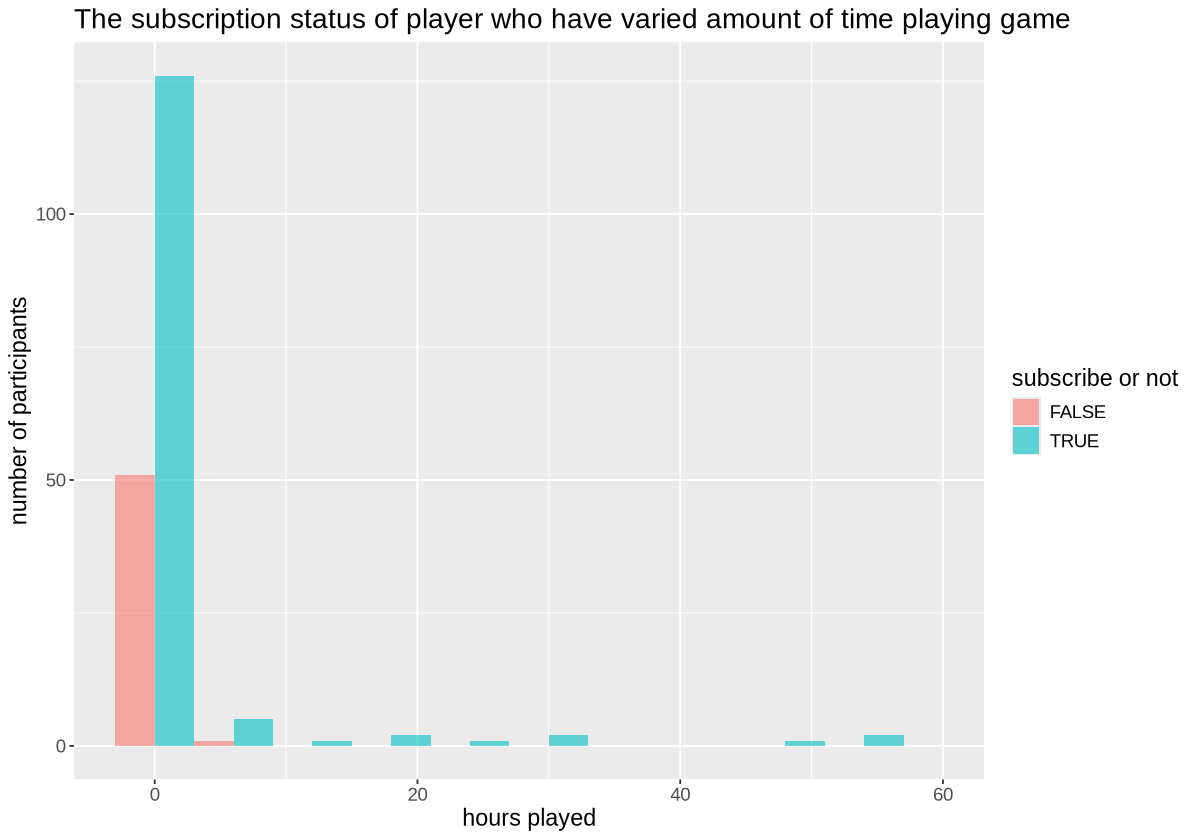

In [8]:
options(repr.plot.height = 7, repr.plot.width = 10)

cleaned_Players_data_histo <- ggplot(cleaned_Players_data, aes(x=played_hours, fill = subscribe)) +
geom_histogram(alpha = 0.6, position = "dodge", binwidth= 6) +
labs(x = "hours played", fill = "subscribe or not", y = "number of participants") +
xlim(-3, 60)+
theme(text = element_text(size = 14)) +
ggtitle("The subscription status of player who have varied amount of time playing game")

cleaned_Players_data_histo

The first graph doesn't have a strong correlation between playing time and subscription status. But, we can generally conclude that most unsubscribed players have 0 hours of played time and most subscribed players played above 0 hours. Also, 4 bars have playing hours far beyond 60 (greater than 150 hours). Therefore, their data would be 'noise' for the general trend. Overall, we can conclude a weak correlation between increasing played hours and possible chances to subscribe (however the data set may be too small to include players who don't subscribe beyond 10 hours playing).

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


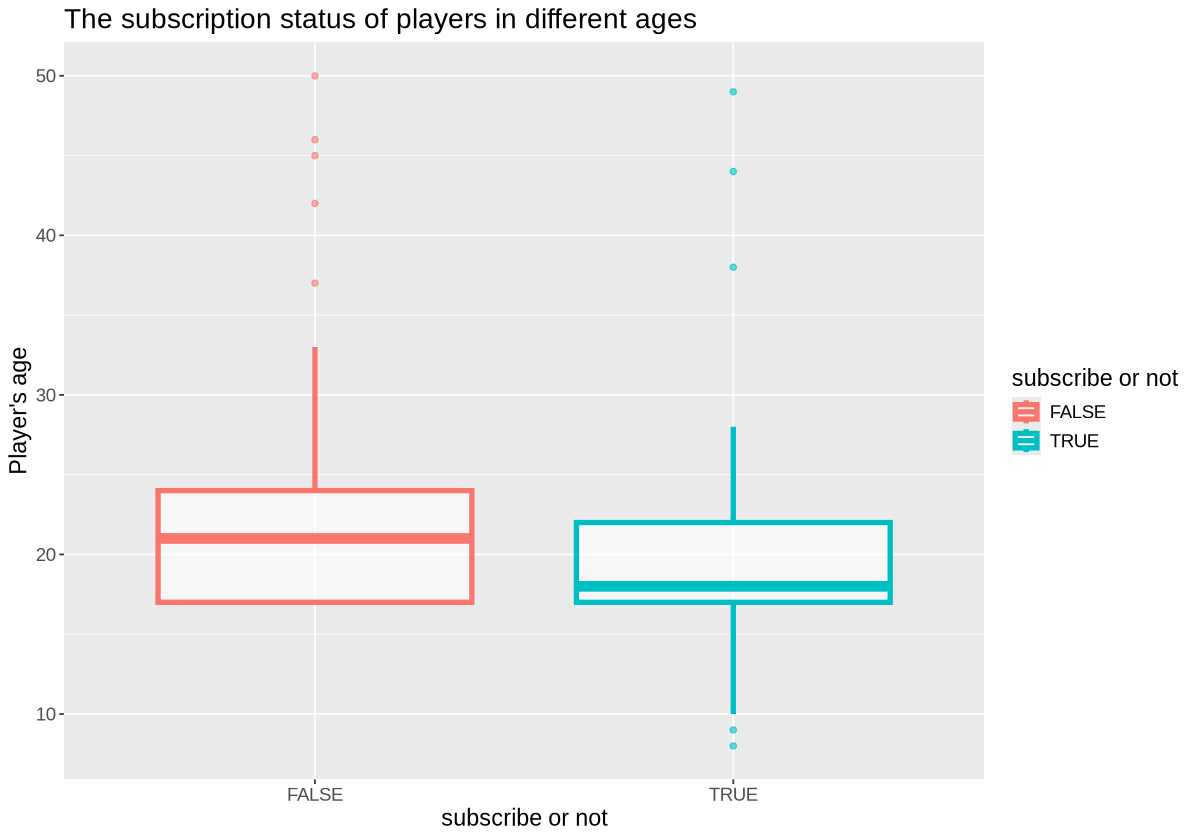

In [9]:
cleaned_Players_data_point <- ggplot(cleaned_Players_data, aes(x=subscribe, y = Age, color = subscribe)) +
geom_boxplot(alpha = 0.6, size = 1.5) +
labs(x = "subscribe or not", y = "Player's age", color = "subscribe or not") +
theme(text = element_text(size = 14)) +
ggtitle("The subscription status of players in different ages")

cleaned_Players_data_point

The second graph doesn't have a strong correlation between age and subscription status. From the graph, most subscribed players are within an age range of around 10 to 28; unsubscribed players are mostly within 17 to 33. Although the two ranges generally overlap, there are still differences: larger age range for subscribed players.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


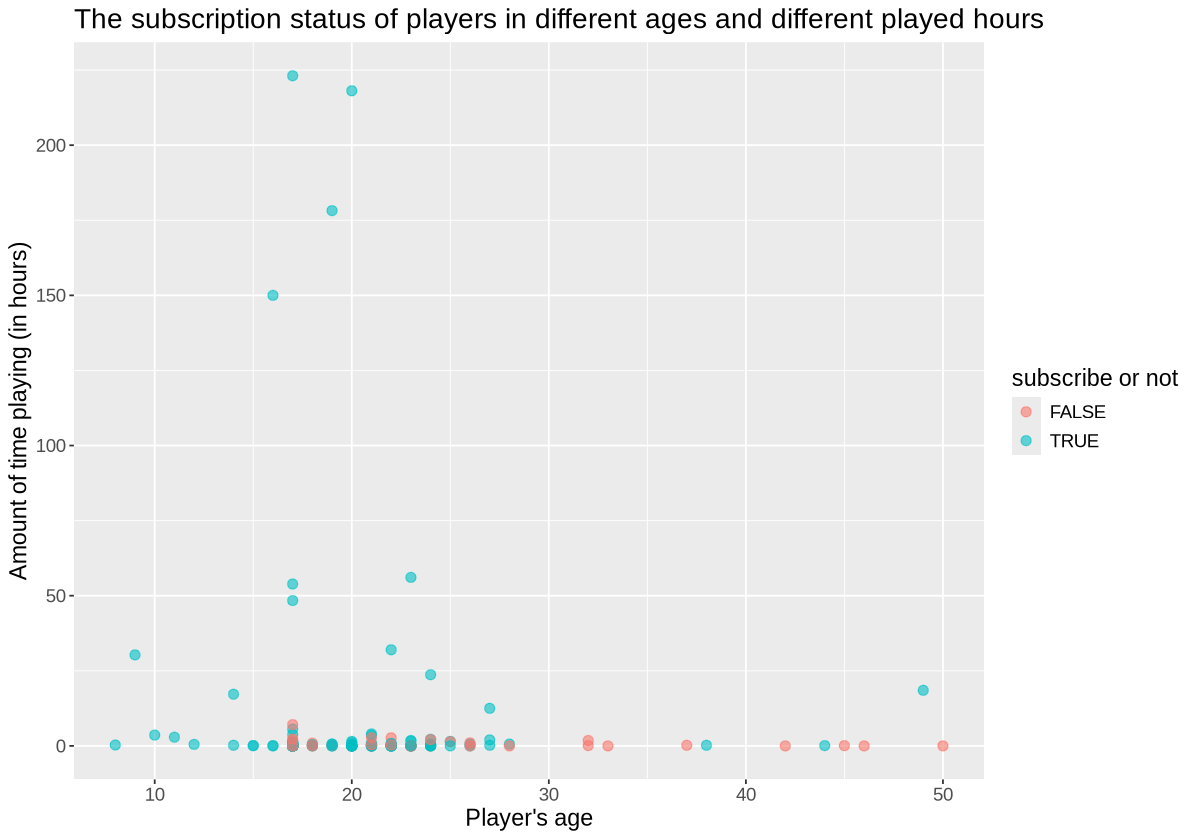

In [10]:
cleaned_Players_data_mix <- ggplot(cleaned_Players_data, aes(x=Age, y = played_hours, color = subscribe)) +
geom_point(alpha = 0.6, size = 2.5) +
labs(x ="Player's age", y = "Amount of time playing (in hours)", color = "subscribe or not") +
theme(text = element_text(size = 14)) +
ggtitle("The subscription status of players in different ages and different played hours")

cleaned_Players_data_mix

To confirm the previous observations, a third graph is conducted with all three variables. The player's age and played time are on the x and y axes, and the subscription status is coloured. On the graph, all players, with played time above 10 hours, have subscribed. Below the age of 30, far more players subscribed; while above 30, the amount of data decreased, but the subscription status became approximately equal.

Also, looking at this graph, we could easily indicate outliers: 4 people who played above 150 hours (they were ignored in the first graph).

# Classification Stage

We can take one step further to investigate the research question. Three methods are learned from class: knn classification, knn regression, and linear regression. However, the response variable for this project is 'subscribe' and it is a logistic or categorical. Therefore, both regression methods can be neglected as they are only valid when a numerical variable is the response variable. 

So, the classification method should be used to furtherly predict new observations with unknown subscription status. Weaknesses also exists in this method. The subscription status is numerically unbalanced meaning that as k increases, it would favour the subscribing group (who has more data points). Also, there are overlapping areas from the third graph which may distract the predictions' accuracy. Last, this data set isn't big enough to contain players with longer playing time while not subscribing (which may be possible for new observations). So, we'll start with dropping the 'NA's previously mentioned in our data.

In [11]:
cleaned_Players_data_2 <- cleaned_Players_data |>
mutate(subscribe = as.factor(subscribe))|>
drop_na()

cleaned_Players_data_2 |>
head()

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


A random numerical value, 2024, was used as the seed to ensure a random, but reproducible sampling. The cleaned_Players_data_2 was split into training and testing datasets using the initial_split function, with 80% of the data being put into the training data by prop = 0.8. The strata argument was set as equal to subscribe, to ensure both datasets include the correct proportion of each category.

In [12]:
set.seed(2024)
Split_Players_data <- cleaned_Players_data_2 |>
initial_split(data = cleaned_Players_data_2, prop=0.8, strata = subscribe)

Players_train <- training(Split_Players_data)   
Players_test <- testing(Split_Players_data)

A recipe was created using recipe() in which subscribe was assigned as the response variable and played_hours and Age were assigned to be predictor variables. The numerical values were standardized using step_scale and step_center.

In [13]:
Players_recipe <- recipe(subscribe ~ played_hours + Age , data = Players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

We want to use the K-nearest neighbours classification model to try and predict whether players are subscribed or not, but we don’t know what the optimal K value is yet. To find it, we will use a tuning model first. We used the nearest_neighbor() function and set the neighbors argument to tune() to tell the model that this value will be optimized in the process. The weight_func was set as equal to rectangular to give equal weighting to each neighbor, so they all have equal influence on the prediction. 

In [14]:
knn_Players_tune <- nearest_neighbor(weight_func = "rectangular",
neighbors = tune())|>
set_engine("kknn") |>
set_mode("classification")

We'll create a data frame of the K values we want to furtherly test. The values start from 1 to 30 by increament of 1.

In [15]:
k_values <- tibble(neighbors = seq(from=1, to=30, by=1))

We perform 5-fold cross-validation to evaluate the accuracy of the classifier using vfold_cv(). Only the training data is used in this evaluation. The strata argument is set to subscribe, the categorical variable, to ensure each validation subset has the correct proportion of each category of observation.

In [16]:
set.seed(2024)
five_fold <- vfold_cv(Players_train, v = 5, strata = subscribe)

A workflow is used to chain together previous analysis steps along with new ones. Both add_recipe and add_model were used to add recipe and model specification  to train the model. The tune_grid() function was used to evaluate the classifiers accuracy across different K values. Within that function the resamples argument runs 5 fold cross validation on the training dataset. The grid argument set to k_values provided the range of K values to try. collect_metrics() collected the evaluation results, and filter(.metric == "accuracy") made it so only the accuracy scores were kept. The select function was used to pull the mean accuracy for each k value

In [35]:
knn_Players_result <- workflow() |>
add_recipe(Players_recipe) |>
add_model(knn_Players_tune) |>
tune_grid(resamples = five_fold, grid = k_values)|>
collect_metrics()|>
filter(.metric == 'accuracy')|>
select(neighbors, mean)

knn_Players_result |>
head()

neighbors,mean
<dbl>,<dbl>
1,0.4344086
2,0.4477419
3,0.5318683
4,0.5183199
5,0.6289113
6,0.6155780


To find the best K-value, we set up a line plot with the knn_Players_result with the x axis being different k values, and the y axis being an estimate of the accuracy. 

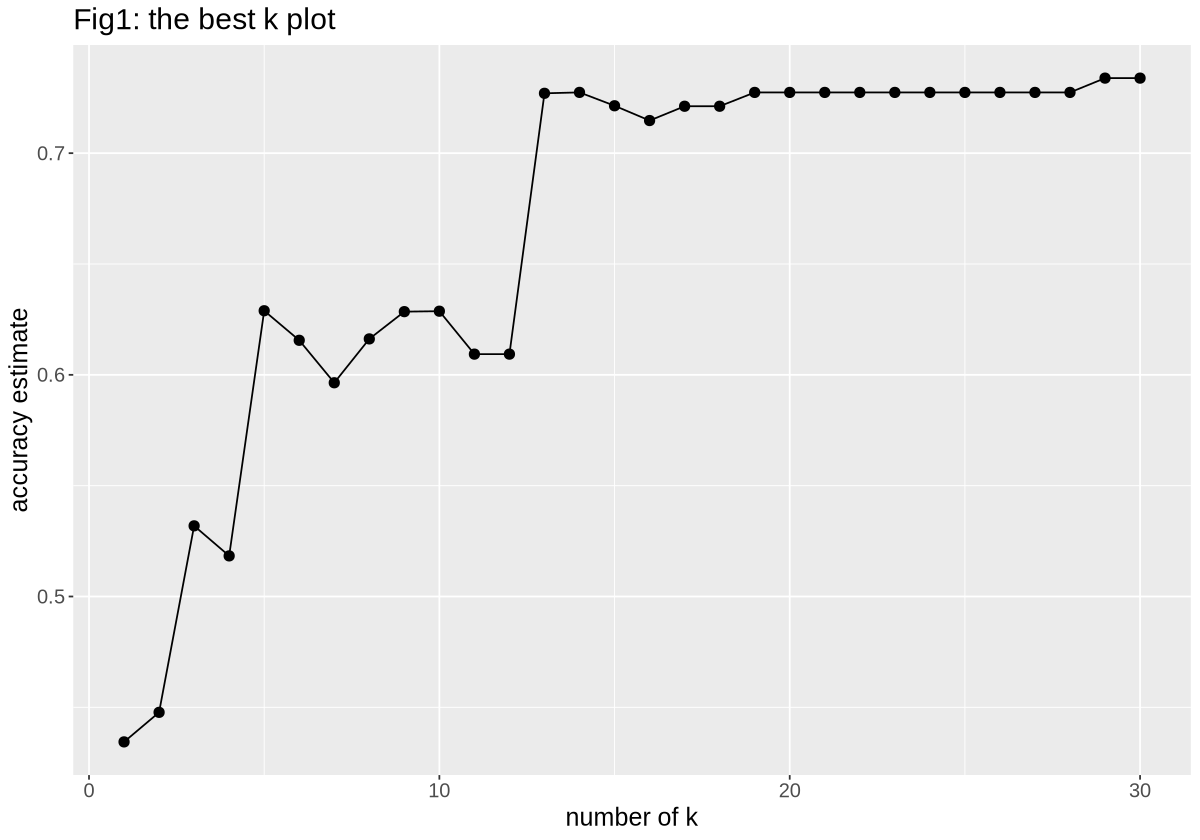

In [18]:
Best_k_plot <- knn_Players_result |>
ggplot(aes(x=neighbors, y= mean))+
geom_point(size = 2.5)+
geom_line()+
labs(x="number of k",y="accuracy estimate")+
ggtitle("Fig1: the best k plot")+
theme(text = element_text(size = 15))

Best_k_plot

By looking at this plot, we choose k=13. Although, it isn't the highest accuracy but it has a high accuracy level with less k which means it would be less affected by the case of more subscribed than unsubscribed, meaning that it is the most optimal k value to use for this model.

We created a specification model with the K value that we just found with the nearest_neighbor() function. Again, this will ensure that our final model uses the KNN Nearest Neighbour algorithm and be used for classification by setting the set_engine() argument to “kknn”, and set mode() argument to “classification. This will later be fitted to the training data for the final model.

In [19]:
knn_Players_spec <- nearest_neighbor(weight_func = "rectangular",
neighbors = 13)|>
set_engine("kknn") |>
set_mode("classification")

We place the new model and the previous recipe in another workflow using add_recipe() and add_model, and then fit the workflow to the training data using fit function.

In [20]:
knn_players_fit <- workflow()|>
add_recipe(Players_recipe) |>
add_model(knn_Players_spec) |>
fit(data = Players_train)

To test the accuracy of our new model, we fed it the testing data that we have remaining using the predict() function, and then bounded the columns for the metrics we are going to check. Now we give the results of our models’ predictions and give it to the metrics() function and use the filter() function to only take the accuracy. 

In [56]:
Players_subscribe_pred <- predict(knn_players_fit, Players_test)|>
bind_cols(Players_test)

Players_metrics <- Players_subscribe_pred|>
metrics(truth=subscribe, estimate=.pred_class)|>
filter(.metric == 'accuracy')

Players_metrics

Predicted_k <- knn_Players_result|>
filter(neighbors==13)
Predicted_k

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.675


neighbors,mean
<dbl>,<dbl>
13,0.7270027


Our model has an accuracy of 67.5%, which is a bit lower in comparison with 72.7% predicted from training data. Now we make a confusion matrix for our model, which just shows the false positives, false negatives, true positives, and true negatives from our model. To do this, we used the conf_mat function.

In [22]:
Players_conf_mat <- Players_subscribe_pred|>
conf_mat(truth = subscribe, estimate = .pred_class)

Players_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     3    5
     TRUE      8   24

Although, the accuracy isn't the highest as it can be. But we can see that R did not merely predicting all datapoints to be true (because subscribed player have a greater amount), which is a useful prediction for the research group.

Now we will compare the predictions to the true classes and create a data frame of our accurate and inaccurate predictions. The accurate variable lists whether the predictions of the observations were correct. It is the only column kept using select() and turned into character type data using mutate().

In [44]:
final_result <- Players_subscribe_pred|> 
mutate(accurate = (.pred_class == subscribe))|>
select(-.pred_class, -subscribe)|>
mutate(accurate = as.character(accurate))

final_result |> 
head()

played_hours,Age,accurate
<dbl>,<dbl>,<chr>
0.1,17,TRUE
48.4,17,TRUE
0.0,17,FALSE
0.0,23,FALSE
0.1,18,FALSE
0.1,23,TRUE


Finally, we will visualize a scatter plot of the age of players on the x axis vs the number of hours played on the y axis, but this time its colored by whether our model classified the point correctly or not. 

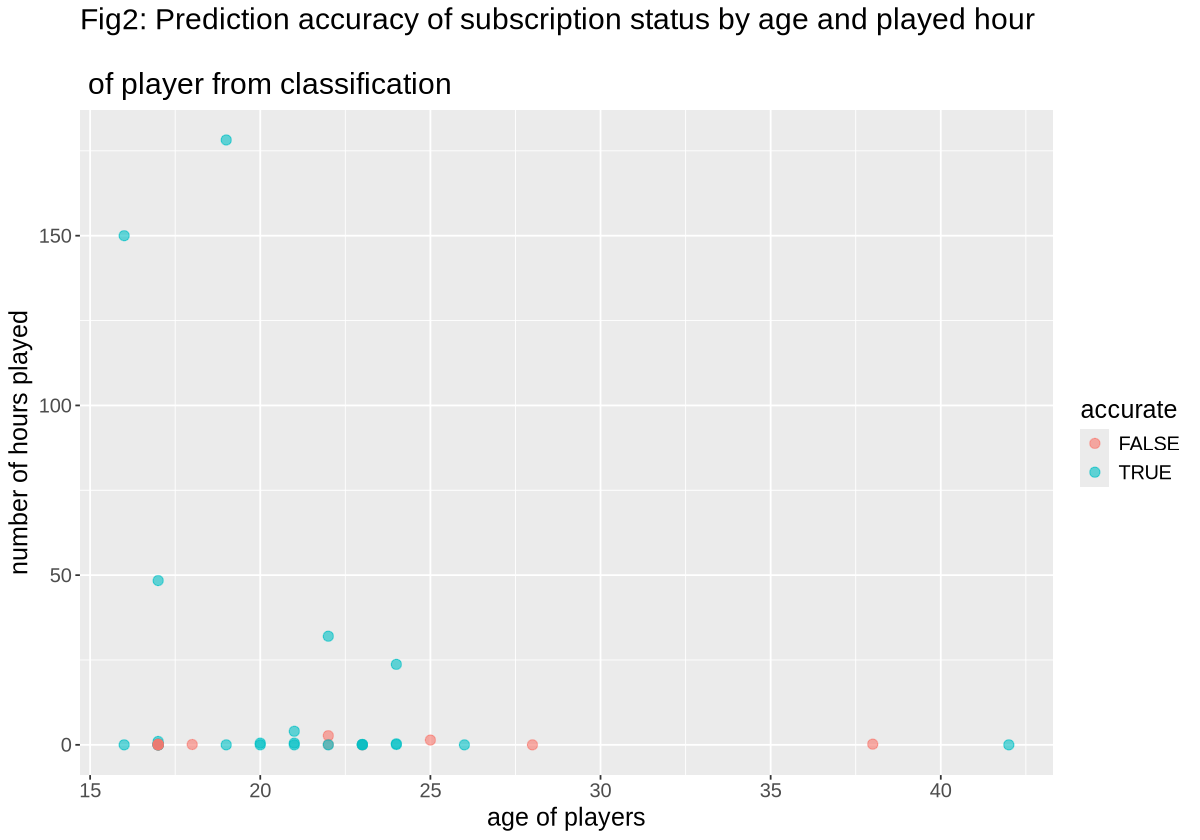

In [85]:
Players_subscribe_pred_accuracy_plot <- final_result|>
ggplot(aes(x=Age, y=played_hours, color = accurate))+
geom_point(alpha= 0.6, size = 2.5)+
labs(x="age of players", y= "number of hours played")+
ggtitle("Fig2: Prediction accuracy of subscription status by age and played hour 
\n of player from classification")+
theme(text = element_text(size = 15))

Players_subscribe_pred_accuracy_plot

We can see our model does a pretty good job at correctly predicting whether the player was subscribed to a game-related newsletter or not in terms of accuracy.

# Discussion

From our analysis above, we found that most players who are subscribed to a game-related newsletter, had a total playtime of over 0 hours, whereas most players who are not subscribed to a game-related newsletter had a playtime of 0 hours. We also found that the average subscribed players’ age range goes from 10-28 years old, and the unsubscribed players’ age range goes from 17-33, which shows that younger players show more interest in games. Through the scatterplot visual that we made, it was found that all the players who had a total playtime of 10 or more hours were subscribed to a game newsletter, and also that for those below the age of 30, a majority of the players are subscribed compared to not. This shows that if they want to get more data from these players, the researchers at UBC should be trying to target the players who are subscribed to a game-related newsletter, and a majority of the players who are subscribed are in the younger age range. We also found that the number of played hours and the age of players can, in fact, be used to predict a player’s subscription status.


This is expected, as those who are subscribed to a game newsletter are typically people who are more interested in games than those who are not subscribed. The age range of the people who are subscribed and those who are not is also expected, as players aged from 15-21 years old account for 43% of the total Minecraft user base (Woodward, 2025), which falls in the age range for the players who are subscribed to the newsletter.

These findings show that the researchers should try and cater towards the younger and subscribed audiences, as they are more likely to spend more time on the MineCraft server. The researchers will get more data from younger people as they will play for longer amounts of time, which means that they will do more and get further into the game than those who play less.


For further research, we can conclude that there is a gap/blank area exists with players with high age (>30) and high playtime, and therefore R classification is more likely to make wrong predictions on players with higher age (>30) when predicting the test dataset. So, we can conduct survey for this group of player for better prediction. And, we can modify new varibale into consideration like gender: Can player gender be used to predict playtime in different age groups? 